In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [162]:
class LoadGenerator:
    """
    Generate load patterns with added Gaussian noise.
    """
    def __init__(self, mean=0, std=1, seed=None, freq=1):
        self.time = 0
        self.freq = freq
        self.mean = mean
        self.std = std
        self.rng = np.random.default_rng(seed)
        
    def gen_load_const(self, steps):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = np.zeros((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_change_val(self, steps, delta):
        new_mean = self.mean + delta
        mean = np.linspace(self.mean, new_mean, steps + 2)[1:-1]
        noise = self.rng.normal(0, self.std, steps)
        values = (mean + noise).reshape((steps, 1))
        self.mean = new_mean
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = np.ones((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_peak_val(self, steps, delta):
        peak = self.mean + delta
        mean = np.concatenate((
            np.linspace(self.mean, peak, np.floor(steps/2).astype(int)+2)[1:-1],
            peak * np.array(np.ones(steps%2)),
            np.linspace(peak, self.mean, np.floor(steps/2).astype(int)+2)[1:-1]
        ))
        noise = self.rng.normal(0, self.std, steps)
        values = (mean + noise).reshape((steps, 1))
        
        times = self.time + np.cumsum(self.rng.exponential(scale=1/self.freq, size=(steps, 1)), axis=0)
        self.time = times[-1]
        
        category = 2*np.ones((steps, 1))
        
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_change_freq(self, steps, alpha):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        new_freq = (1 + alpha)*self.freq
        freqs = np.linspace(self.freq, new_freq, steps + 2)[1:-1]
        times = self.time + np.cumsum([self.rng.exponential(scale=1/freq) for freq in freqs]).reshape((steps, 1))
        self.time = times[-1]
        self.freq = freqs[-1]
                
        category = 3*np.ones((steps, 1))
                
        return np.concatenate((times, values, category), axis=1)
    
    def gen_load_peak_freq(self, steps, alpha):
        values = self.rng.normal(self.mean, self.std, size=(steps, 1))
        
        peak = (1 + alpha)*self.freq
        freqs = np.concatenate((
            np.linspace(self.freq, peak, np.floor(steps/2).astype(int)+2)[1:-1],
            peak * np.array(np.ones(steps%2)),
            np.linspace(peak, self.freq, np.floor(steps/2).astype(int)+2)[1:-1]
        ))
        times = self.time + np.cumsum([self.rng.exponential(scale=1/freq) for freq in freqs]).reshape((steps, 1))
        self.time = times[-1]
        self.freq = freqs[-1]
                
        category = 4*np.ones((steps, 1))
                
        return np.concatenate((times, values, category), axis=1)
    
    
def generate_stream(length=1000, episode_length=10, episode_variability=0.5, intensity=0.1,
                    start_mean=0, noise_std=1, abs_delta_mean=None, delta_var=None,
                    abs_alpha_min=0.2, abs_alpha_max=0.8, seed=None):
    """
    Generate a data stream with load changes and peaks.
    """
    rng = np.random.default_rng(seed)
    lgen = LoadGenerator(start_mean, noise_std, rng)
    
    min_ep_len = np.floor(episode_length*(1 - episode_variability)).astype(int)
    max_ep_len = np.ceil(episode_length*(1 + episode_variability)).astype(int)
    if not abs_delta_mean:
        abs_delta_mean = 5*noise_std
    if not delta_var:
        delta_var = noise_std
    
    stream = np.empty((0, 3))
    while len(stream) < length:
        ep_len = rng.integers(min_ep_len, max_ep_len)
        ep_category = rng.choice(a=5, p=[1 - intensity] + [intensity/4 for _ in range(4)])
        if ep_category == 0:
            episode = lgen.gen_load_const(ep_len)
            stream = np.concatenate((stream, episode))
        elif ep_category == 1:
            delta = rng.choice([-1, 1])*rng.normal(abs_delta_mean, delta_var)
            episode = lgen.gen_load_change_val(ep_len, delta)
            stream = np.concatenate((stream, episode))
        elif ep_category == 2:
            delta = rng.choice([-1, 1])*rng.normal(abs_delta_mean, delta_var)
            episode = lgen.gen_load_peak_val(ep_len, delta)
            stream = np.concatenate((stream, episode))
        elif ep_category == 3:
            alpha = rng.choice([-1, 1])*rng.uniform(abs_alpha_min, abs_alpha_max)
            episode = lgen.gen_load_change_freq(ep_len, alpha)
            stream = np.concatenate((stream, episode))
        elif ep_category == 4:
            alpha = rng.choice([-1, 1])*rng.uniform(abs_alpha_min, abs_alpha_max)
            episode = lgen.gen_load_peak_freq(ep_len, alpha)
            stream = np.concatenate((stream, episode))
        else:
            raise Exception("Unexpected episode category")
        
    return stream

In [163]:
stream = generate_stream(length=1000, episode_length=20)

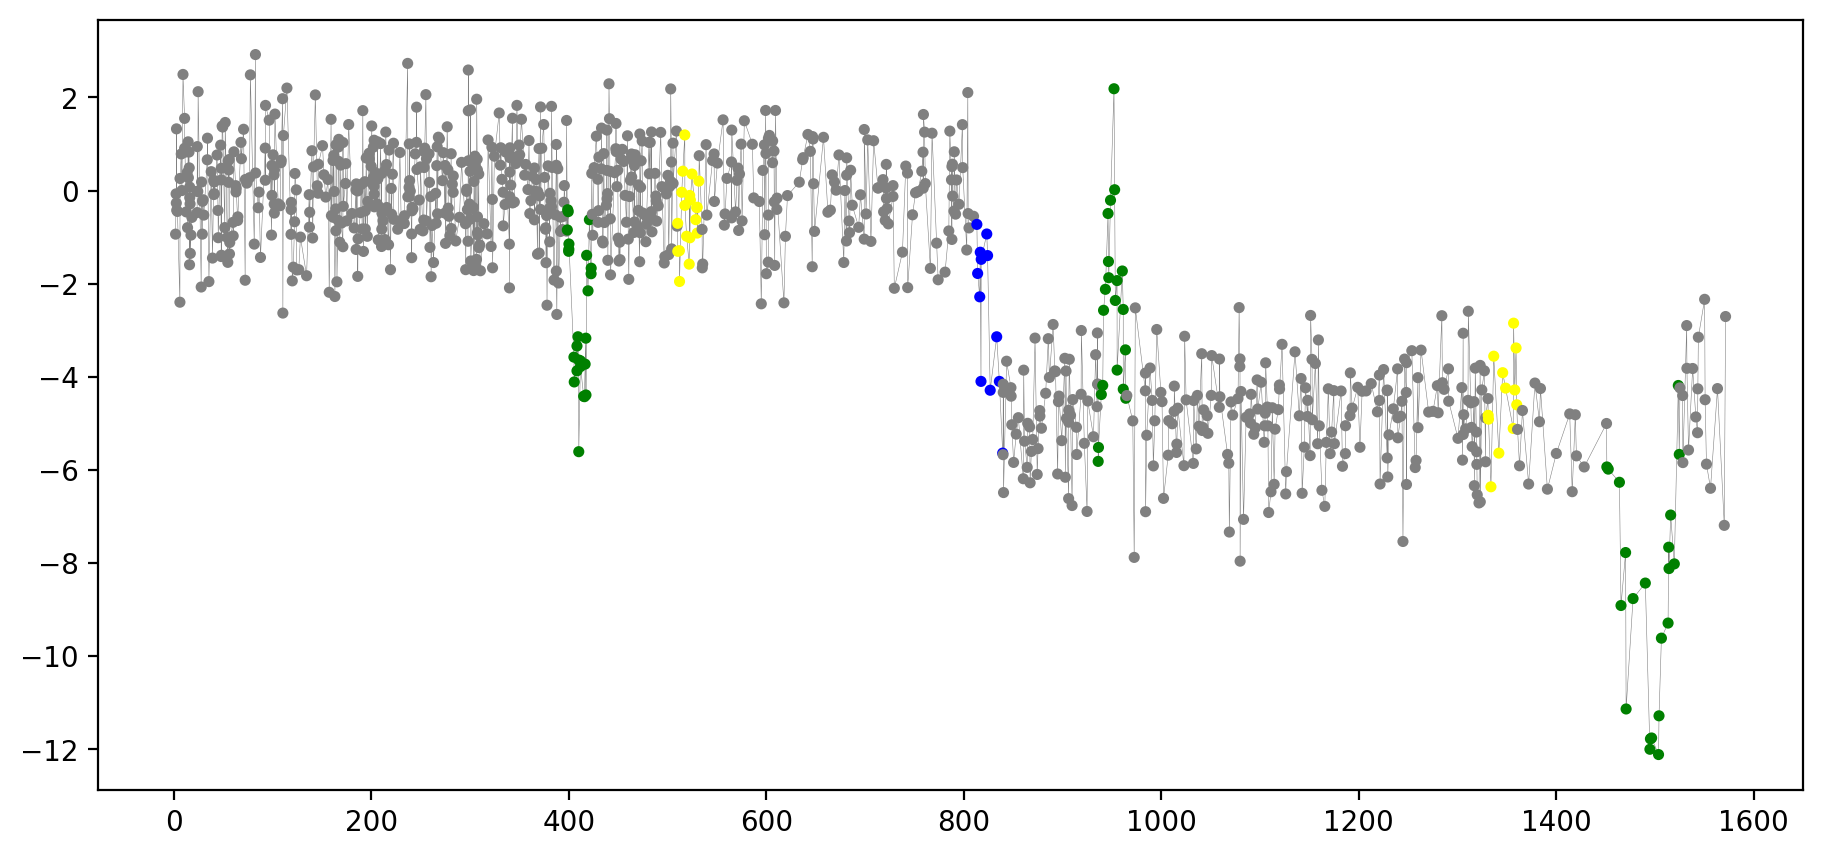

In [166]:
colormap = {0:'gray', 1:'blue', 2:'green', 3:'yellow', 4:'red'}
colors = list(map(lambda x: colormap[x], stream[:,2]))
plt.figure(figsize=(11, 5), dpi=200)
plt.plot(stream[:,0], stream[:,1], color='gray', linewidth=0.2, zorder=0);
plt.scatter(stream[:,0], stream[:,1], marker='.', c=colors, zorder=1);
plt.show()

# plt.scatter(stream[:,0], stream[:,1], c=stream[:,2], cmap='viridis')